<a href="https://colab.research.google.com/github/mihirsakaria/solving-maths-problems-in-hindi/blob/main/problem_solver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
import numpy as np
import os

In [2]:
# !pip install python-docx
# #Not needed

In [3]:
# import docx
# #Not needed

In [4]:
f1 = 'drive/MyDrive/Maths Problem Solving BTP/data/'

In [5]:

# def getText(filename):
#     doc = docx.Document(f1+filename)
#     fullText = []
#     for para in doc.paragraphs:
#         fullText.append(para.text)
#     return '\n'.join(fullText)
# print(os.listdir('drive/MyDrive/Maths Problem Solving BTP/data'))
# files = os.listdir('drive/MyDrive/Maths Problem Solving BTP/data')
# #Not needed

In [6]:
# texts = []
# for f in files:
#   if f == '.DS_Store':
#     continue 
#   if '.pkl' not in f and '.json' not in f:
#     texts.append(getText(f))
# #Not needed

In [7]:
# questions = []
# equations = []
# for text in texts:
#   for line in text.split('\n')[1:]:
#     if 'Question :' in line:
#       q = line[len('Question : \"'):-1]
#       questions.append(q)
#     if 'Equation :' in line:
#       e = line[len('Equation : \" '):-1]
#       equations.append(e)
#   #Not needed

In [8]:
# len(questions), len(equations)
# #Not needed

In [9]:
# np.random.choice(questions, 10)
# #Not needed

In [10]:
import json
questions = []
equations= []
with open('Dataset.json','r',encoding='utf-8') as f:
  obj = json.load(f)
  for i in obj:
    questions.append(i["question"])
    equations.append(i["equation"])

In [11]:
import pandas as pd
data = pd.DataFrame({'Question':questions, 'Equation':equations})

In [12]:
# # data = data.head(8000)
# data

In [13]:
# #Not needed
# data_json = pd.read_json(f1+'OneVariableSingleEQ.json')

In [14]:
# data_2 = pd.DataFrame({'Question':list(data_json['sQuestion'].values), 'Equation':list(data_json['lEquations'].apply(lambda x: x[0]).values)})
# data_2
# #Not needed

In [15]:
# #Not needed
# data_final = data.append(data_2)
# data_final = data_final.sample(frac=1)
# with open('data_final.pkl','wb') as f:
#   pickle.dump(data_final, f)

In [16]:
# data_final = data.append(data_2)
data_final = data
data_final = data_final.sample(frac=1)
with open('data_final.pkl','wb') as f:
  pickle.dump(data_final, f)

In [17]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [18]:
tf.__version__

'2.7.0'

In [19]:
with open('data_final.pkl', 'rb') as f:
  df = pickle.load(f)

In [20]:
df.shape
df.head()

def convert_eqn(eqn):
  '''
  Add a space between every character in the equation string.
  Eg: 'x = 23 + 88' becomes 'x =  2 3 + 8 8'
  '''
  elements = list(eqn)
  return ' '.join(elements)

In [21]:
input_exps = list(df['Question'].values)
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)
target_exps = list(df['Equation'].values)
input_exps[:5]
target_exps[:5]
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(12500, 9741)

In [22]:
def preprocess_input(sentence):
  '''
  For the word problem, convert everything to lowercase, add spaces around all
  punctuations and digits, and remove any extra spaces. 
  '''
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’।])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return sentence

In [23]:
def preprocess_target(sentence):
  '''
  For the equation, convert it to lowercase and remove extra spaces
  '''
  sentence = sentence.lower().strip()
  return sentence

In [24]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [25]:
def wordTokenize(text):
  return text.split(" ")
#Tokenising a text, removing stopwords and cleaning it
def clean_text_initial(text):
    text = "".join(text.split(","))
    text = "".join(text.split("."))
    text = "".join(text.split("।"))
    text = "".join(text.split("?"))
    
    text = "".join(text.split("/"))
    text = " ".join(text.split())
    # text = ' '.join([x.lower() for x in wordTokenize(text) if x.lower() not in unwanted_list])
    # text = ''.join([i for i in text if not i.isdigit()])
    
    return text

def create_vocab(train):
  unique_words = set()
  for text in train:
    tokens = wordTokenize(text)
    for token in tokens:
      unique_words.add(token)
  vocab = {}
  reverse_vocab= {}
  for index, word in enumerate(list(unique_words)):
    vocab[word] = index+1         #index+1 for transfor
    reverse_vocab[index+1] = word
  return vocab,reverse_vocab


  
def Vectorisation_normal(train):
  vectors = []
  vocab,reverse_vocab = create_vocab(train)
  # print(vocab)
  train_size = len(train)
  vocab_length = len(vocab)
  # for i in range(train_size):
  #   temp = []
  #   for j in range(len(create_vocab([train[i]]))):
  #     temp.append(0)
  #   vectors.append(temp)
  for i in range(train_size):
    tokens = wordTokenize(train[i])
    temp  = []
    for j, token in enumerate(tokens):
      index = vocab[token]
      temp.append(index)
      # vectors[i][j] = index
    vectors.append(temp)
  # vectors = np.array(vectors)
  # vectors = tf.convert_to_tensor(vectors, dtype=tf.int64) 
  return vectors,vocab,reverse_vocab

In [26]:
input_tensor, inp_lang_tokenizer,inp_lang_reverse_tokenizer = Vectorisation_normal(preprocessed_input_exps)
target_tensor , targ_lang_tokenizer,targ_lang_reverse_tokenizer = Vectorisation_normal(preprocessed_target_exps)
old_len = len(targ_lang_tokenizer)

In [27]:
# #Not needed
# preprocessed_input_exps[:5]
# preprocessed_target_exps[:5]
# def tokenize(lang):
#   '''
#   Tokenize the given list of strings and return the tokenized output
#   along with the fitted tokenizer.
#   '''
#   lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#   lang_tokenizer.fit_on_texts(lang)
#   tensor = lang_tokenizer.texts_to_sequences(lang)
#   return tensor, lang_tokenizer
  
# input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)
# len(inp_lang_tokenizer.word_index)
# target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)
# old_len = len(targ_lang_tokenizer.word_index)

In [28]:
print(len(input_tensor[1]),len(inp_lang_tokenizer))

31 2553


In [29]:
def append_start_end(x,last_int):
  '''
  Add integers for start and end tokens for input/target exps
  '''
  l = []
  l.append(last_int+1)
  l.extend(x)
  l.append(last_int+2)
  return l

input_tensor_list = [append_start_end(i,len(inp_lang_tokenizer)) for i in input_tensor]
target_tensor_list = [append_start_end(i,len(targ_lang_tokenizer)) for i in target_tensor]
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor_list, padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor_list, padding='post')


input_tensor
target_tensor
keys = [str(i) for i in range(10,51)]
for i,k in enumerate(keys):
  targ_lang_tokenizer[k]=len(targ_lang_tokenizer)+i+4

len(targ_lang_tokenizer)

440

In [30]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor,test_size=0.05,random_state=42)
len(input_tensor_train)
len(input_tensor_val)

625

In [31]:

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = len(inp_lang_tokenizer)+3
target_vocab_size = len(targ_lang_tokenizer)+3
dropout_rate = 0.0

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 44]), TensorShape([64, 7]))

In [32]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [34]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]

In [35]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [36]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [38]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # normalize data per feature instead of batch
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # Multi-head attention layer
    attn_output, _ = self.mha(x, x, x, mask) 
    attn_output = self.dropout1(attn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out1 = self.layernorm1(x + attn_output)
    
    # Feedforward layer
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    # Create encoder layers (count: num_layers)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    # Masked multihead attention layer (padding + look-ahead)
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    # again add residual connection
    out1 = self.layernorm1(attn1 + x)
    
    # Masked multihead attention layer (only padding)
    # with input from encoder as Key and Value, and input from previous layer as Query
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    # again add residual connection
    out2 = self.layernorm2(attn2 + out1)
    
    # Feedforward layer
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    # again add residual connection
    out3 = self.layernorm3(ffn_output + out2)
    return out3, attn_weights_block1, attn_weights_block2

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
     
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    # Create decoder layers (count: num_layers)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    x += self.pos_encoding[:,:seq_len,:]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      # store attenion weights, they can be used to visualize while translating
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    return x, attention_weights

In [43]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    # Pass the input to the encoder
    enc_output = self.encoder(inp, training, enc_padding_mask)
    
    # Pass the encoder output to the decoder
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    # Pass the decoder output to the last linear layer
    final_output = self.final_layer(dec_output)
    
    return final_output, attention_weights

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(d_model)

# Adam optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [47]:
def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [49]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [50]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Decoder padding mask
  dec_padding_mask = create_padding_mask(inp)
  
  # Look ahead mask (for hiding the rest of the sequence in the 1st decoder attention layer)
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [51]:
checkpoint_dir = os.path.join(f1, "ADL Project/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "training_checkpoints/akshata_transfomer")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

Checkpoints directory is drive/MyDrive/Maths Problem Solving BTP/data/ADL Project/checkpoints/training_checkpoints/akshata_transfomer
Creating a checkpoints directory


In [52]:
latest = ckpt_manager.latest_checkpoint
print(latest)

None


In [53]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
  print ('Latest checkpoint restored!!')
else:
  epoch_num = 0

epoch_num

0

In [54]:
EPOCHS = 30

def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [55]:
for epoch in range(epoch_num, EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> question, tar -> equation
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.0068 Accuracy 0.0000
Epoch 1 Batch 50 Loss 5.5356 Accuracy 0.0920
Epoch 1 Batch 100 Loss 5.0024 Accuracy 0.1985
Epoch 1 Batch 150 Loss 4.3994 Accuracy 0.3163
Saving checkpoint for epoch 1 at drive/MyDrive/Maths Problem Solving BTP/data/ADL Project/checkpoints/training_checkpoints/akshata_transfomer/ckpt-1
Epoch 1 Loss 4.0586 Accuracy 0.3798
Time taken for 1 epoch: 75.1310076713562 secs

Epoch 2 Batch 0 Loss 2.3651 Accuracy 0.6641
Epoch 2 Batch 50 Loss 2.2420 Accuracy 0.6616
Epoch 2 Batch 100 Loss 2.1411 Accuracy 0.6615
Epoch 2 Batch 150 Loss 2.0631 Accuracy 0.6626
Saving checkpoint for epoch 2 at drive/MyDrive/Maths Problem Solving BTP/data/ADL Project/checkpoints/training_checkpoints/akshata_transfomer/ckpt-2
Epoch 2 Loss 2.0189 Accuracy 0.6634
Time taken for 1 epoch: 72.67309832572937 secs

Epoch 3 Batch 0 Loss 1.8345 Accuracy 0.6641
Epoch 3 Batch 50 Loss 1.7422 Accuracy 0.6733
Epoch 3 Batch 100 Loss 1.6871 Accuracy 0.6799
Epoch 3 Batch 150 Loss 1.6312 Accuracy

In [56]:
def evaluate(inp_sentence):
  start_token = [len(inp_lang_tokenizer)+1]
  end_token = [len(inp_lang_tokenizer)+2]
  
  # inp sentence is the word problem, hence adding the start and end token
  inp_sentence = start_token + [inp_lang_tokenizer[i] for i in preprocess_input(inp_sentence).split(' ')]+end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # start with equation's start token
  decoder_input = [old_len+1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :] 
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == old_len+2:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  return tf.squeeze(output, axis=0), attention_weights

In [57]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = preprocess_input(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence.split(' '))+2))
    ax.set_yticks(range(len([targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer) and i not in [0,old_len+1,old_len+2]])+3))
    
    
    ax.set_ylim(len([targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer) and i not in [0,old_len+1,old_len+2]]), -0.5)
        
    ax.set_xticklabels(
        ['<start>']+sentence.split(' ')+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer) and i not in [0,old_len+1,old_len+2]], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [58]:
old_len

440

In [59]:
MAX_LENGTH = 40
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  # print('result',list(result.numpy()))

  # use the result tokens to convert prediction into a list of characters
  # (not inclusing padding, start and end tokens)
  # predicted_sentence = [targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) if (i < len(targ_lang_tokenizer) and i not in [0,46,47])]  
  predicted_sentence = [targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) if (i < len(targ_lang_tokenizer) and i not in [0,old_len+1,old_len+2])] 
  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(' '.join(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [60]:
def evaluate_results(inp_sentence):
  start_token = [len(inp_lang_tokenizer)+1]
  end_token = [len(inp_lang_tokenizer)+2]
  
  # inp sentence is the word problem, hence adding the start and end token
  inp_sentence = start_token + list(inp_sentence.numpy()[0]) + end_token
  
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  
  decoder_input = [old_len+1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == old_len+2:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [61]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [62]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 10 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')
  target_sentence = ''
  
  for i in target_val_batch.numpy()[0]:
    if i not in [0,old_len+1,old_len+2]:
      target_sentence += (targ_lang_reverse_tokenizer[i] + ' ')
  
  y_true.append([target_sentence.split(' ')[:-1]])
  
  result, _ = evaluate_results(inp_val_batch)
  predicted_sentence = [targ_lang_reverse_tokenizer[i] for i in list(result.numpy()) if (i < len(targ_lang_tokenizer) and i not in [0,old_len+1,old_len+2])] 
  y_pred.append(predicted_sentence)
  
  if target_sentence.split(' ')[:-1] == predicted_sentence:
    acc_cnt += 1

10
Accuracy count:  7
------------------
20
Accuracy count:  15
------------------
30
Accuracy count:  22
------------------
40
Accuracy count:  30
------------------
50
Accuracy count:  36
------------------
60
Accuracy count:  42
------------------
70
Accuracy count:  49
------------------
80
Accuracy count:  53
------------------
90
Accuracy count:  60
------------------
100
Accuracy count:  66
------------------
110
Accuracy count:  71
------------------
120
Accuracy count:  76
------------------
130
Accuracy count:  82
------------------
140
Accuracy count:  90
------------------
150
Accuracy count:  98
------------------
160
Accuracy count:  103
------------------
170
Accuracy count:  112
------------------
180
Accuracy count:  116
------------------
190
Accuracy count:  121
------------------
200
Accuracy count:  128
------------------
210
Accuracy count:  134
------------------
220
Accuracy count:  140
------------------
230
Accuracy count:  148
------------------
240
Accuracy 

In [63]:

len(y_true), len(y_pred)
print('Corpus BLEU score of the model: ', corpus_bleu(y_true, y_pred))
print('Accuracy of the model: ', acc_cnt/len(input_tensor_val))
check_str = ' '.join([inp_lang_reverse_tokenizer[i] for i in input_tensor_val[130] if i not in [0,
                                                                                                  len(inp_lang_tokenizer)+1,
                                                                                                  len(inp_lang_tokenizer)+2]])


Corpus BLEU score of the model:  0.8014935870049475
Accuracy of the model:  0.6432


Input: थेरेसा कुछ लीची 1 7 दोस्तों के बीच बांटना चाहती है । यदि प्रत्येक मित्र को 1 6 लीची मिलती है , तो कितने लीची जॉन होंगे ?
Predicted translation: x = 16 * 17


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s

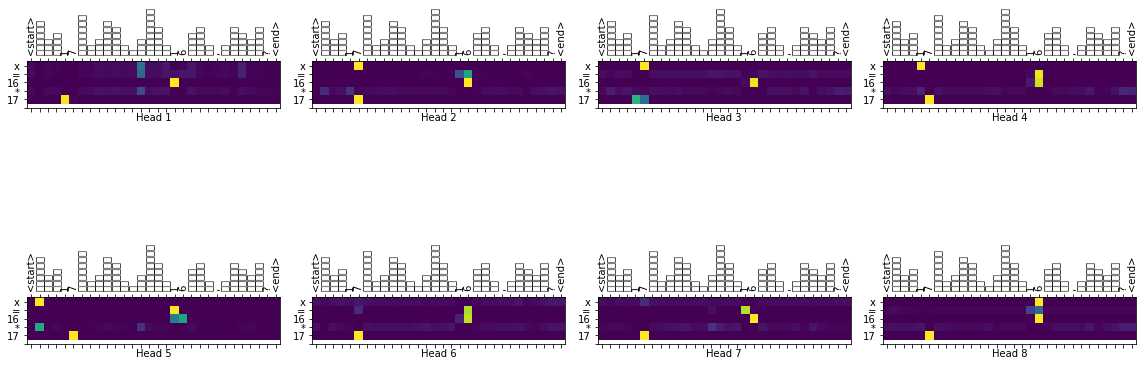

'पामेला 3 दोस्तों के बीच कुछ कार साझा करना चाहती है । यदि प्रत्येक मित्र को 3 1 कार मिलती है , तो कितने कार जॉन होंगे ?'

In [64]:

check_str
translate(check_str,plot='decoder_layer4_block2')
check_str = ' '.join([inp_lang_reverse_tokenizer[i] for i in input_tensor_val[0] if i not in [0,
                                                                                                  len(inp_lang_tokenizer)+1,
                                                                                                  len(inp_lang_tokenizer)+2]])
check_str

Input: पामेला 3 दोस्तों के बीच कुछ कार साझा करना चाहती है । यदि प्रत्येक मित्र को 3 1 कार मिलती है , तो कितने कार जॉन होंगे ?
Predicted translation: x = 31 * 3


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s

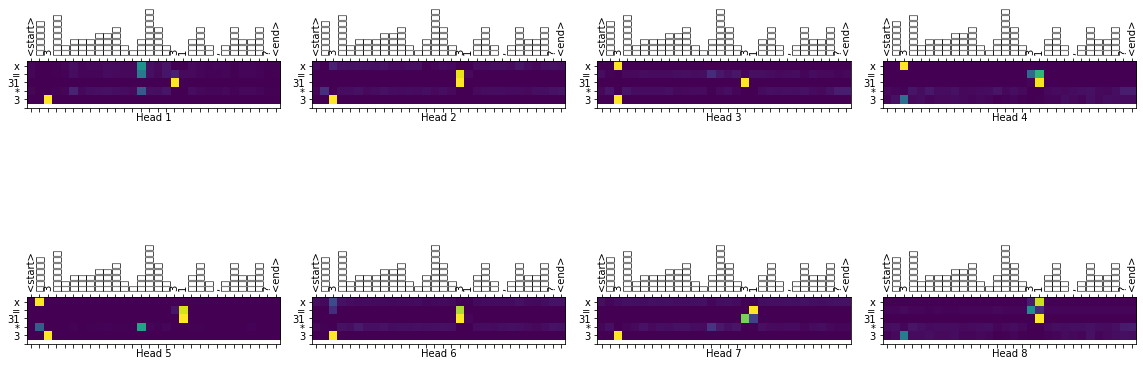

In [66]:
translate(check_str,
          plot='decoder_layer4_block2')

In [67]:
check_str = ' '.join([inp_lang_reverse_tokenizer[i] for i in input_tensor_val[110] if i not in [0,
                                                                                                  len(inp_lang_tokenizer)+1,
                                                                                                  len(inp_lang_tokenizer)+2]])
check_str

'मिल्ड्रेड के पास 6 7 संतरे थे । उसने सभी संतरे को कुछ दोस्तों के बीच समान रूप से आधा कर दिया । कितने दोस्त थे , अगर उसके प्रत्येक दोस्त को 2 8 संतरे मिलते हैं ?'

Input: मिल्ड्रेड के पास 6 7 संतरे थे । उसने सभी संतरे को कुछ दोस्तों के बीच समान रूप से आधा कर दिया । कितने दोस्त थे , अगर उसके प्रत्येक दोस्त को 2 8 संतरे मिलते हैं ?
Predicted translation: x = 67 / 28


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s

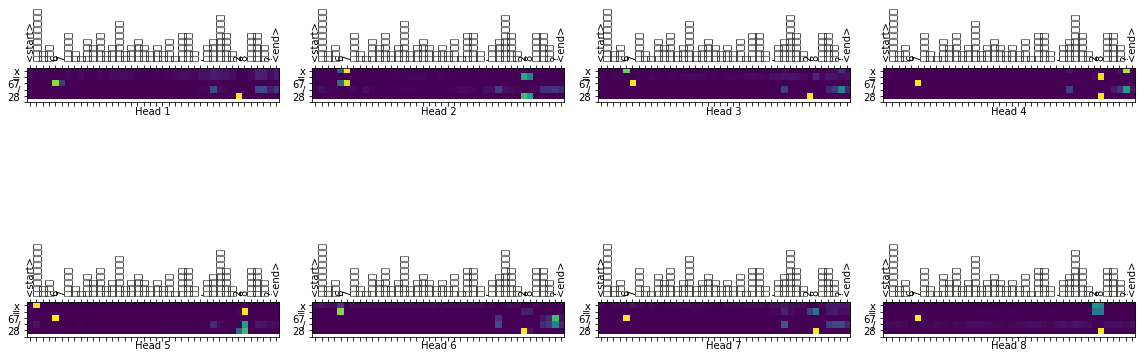

In [68]:
translate(check_str,
          plot='decoder_layer4_block2')

Input: कारी 40 दोस्तों के बीच कुछ ब्लैकबेरी साझा करना चाहता है। यदि प्रत्येक मित्र को 8 ब्लैकबेरी मिलते हैं, तो कितने ब्लैकबेरी जॉन होंगे?
Predicted translation: x = 8 * 40


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s

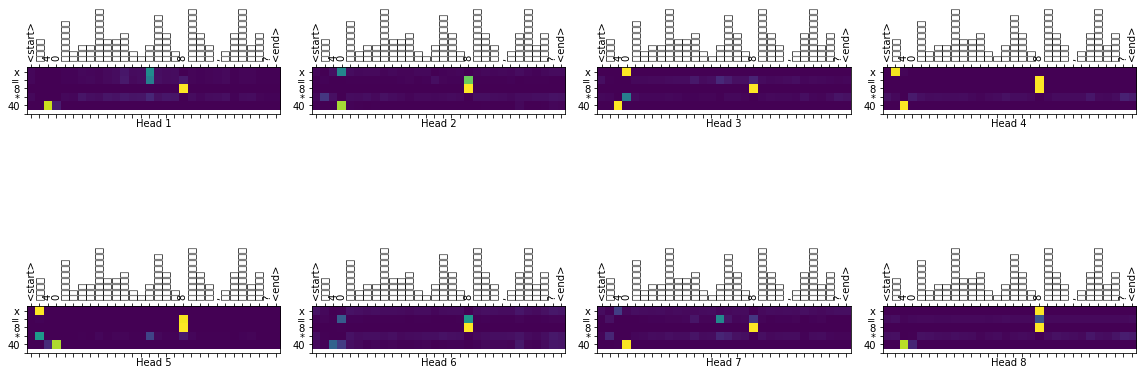

In [69]:
translate("कारी 40 दोस्तों के बीच कुछ ब्लैकबेरी साझा करना चाहता है। यदि प्रत्येक मित्र को 8 ब्लैकबेरी मिलते हैं, तो कितने ब्लैकबेरी जॉन होंगे?",
          plot='decoder_layer4_block2')

Input: जोआन के पास 142 घडी थी। ब्रैंडन ने उससे 136 घडी ली। अब कितनी घडी जोआन कम हो गई है?
Predicted translation: x = 142 - 136


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2332 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s

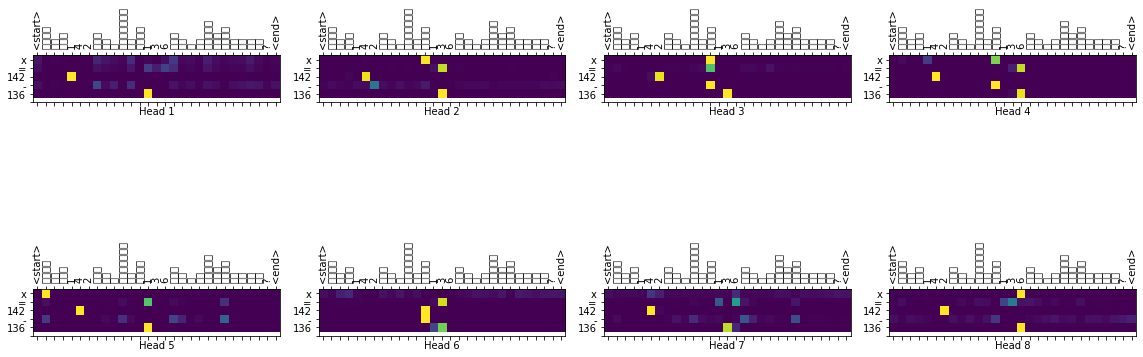

In [70]:
checkStr = "जोआन के पास 142 घडी थी। ब्रैंडन ने उससे 136 घडी ली। अब कितनी घडी जोआन कम हो गई है?"
translate(checkStr,
          plot='decoder_layer4_block2')